### Tess Vu
### MUSA 6950
### Dr. Li
# **Assignment 5: Build Your Own Neural Network for Image Classification**

The assignment is to develop a more complicated neural network and increase the classification accuracy. In the tutorial, we talked about the basic idea of a Neural network and built a simple CNN, and used the pretrained ResNet for image classification. Our simple CNN model only have a couple of layers of convolution and pool layers. If you check the ResNet (was one of the most popular and widely used models for many image classification tasks), the model is much deeper and more complicated.

Don't try to be the hero, but please try your best to add a couple of layers and see how accurate your own CNNs can achieve. With the limits of Colab, don't try to make it too deep, as it needs more time for training.

## Enabling GPU in Google Colab

In [18]:
# Standard libraries.
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization.
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image

# Deep Learning libraries.
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Set seed for reproducibility.
SEED = 42
np.random.seed(SEED)

In [19]:
# Check if GPU is enabled.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model.
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: NVIDIA A100-SXM4-80GB


## Mount Drive

In [20]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


## EuroSAT Dataset
The [EuroSAT dataset](https://github.com/phelber/EuroSAT) contains 27,000 labelled 64x64 pixel Sentinel-2 satellite image patches with 10 different LULC categories. Both RGB and multi-spectral (MS) images are available for download. For simplicity, we will focus on RGB image classification.

In [21]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d "EuroSAT/"
!rm EuroSAT.zip

--2025-10-29 18:09:58--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  4.54MB/s    in 24s     

2025-10-29 18:10:22 (3.81 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]

replace EuroSAT/2750/River/River_479.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Generate Train and Test Sets
### Create Custom Dataset Class

In [22]:
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations.
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]

        # Get class label.
        y = self.dataset[index][1]
        return x, y

    def __len__(self):
        return len(self.dataset)

### Data Augmentation and Image Normalization

In [23]:
input_size = 224

imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

### Load EuroSAT Dataset

In [24]:
# Load the dataset.
data_dir = "./EuroSAT/2750/"
dataset = datasets.ImageFolder(data_dir)

# Get LULC categories.
class_names = dataset.classes

print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


### Split into Train, Validation, and Test Sets

In [25]:
# Apply different transformations to the training and test sets.
train_data = EuroSAT(dataset, train_transform)
val_data = EuroSAT(dataset, val_transform)
test_data = EuroSAT(dataset, test_transform)

# Randomly split the dataset into 70% train / 15% val / 15% test by subsetting the transformed train and test datasets.
train_size = 0.70
val_size = 0.15
indices = list(range(int(len(dataset))))
train_split = int(train_size * len(dataset))
val_split = int(val_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices = indices[:train_split])
val_data = data.Subset(val_data, indices = indices[train_split:train_split + val_split])
test_data = data.Subset(test_data, indices = indices[train_split + val_split:])

print("Train/val/test sizes: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))

Train/val/test sizes: 18900/4050/4050


In [26]:
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_data, batch_size = batch_size, num_workers = num_workers, shuffle = True
)
val_loader = data.DataLoader(
    val_data, batch_size = batch_size, num_workers = num_workers, shuffle = False
)
test_loader = data.DataLoader(
    test_data, batch_size = batch_size, num_workers = num_workers, shuffle = False
)

### Build a Simple CNN Model for Image Classification

Trial and error documentation in trying to mimic ResNet's architecture:

- ResNet goes from 128 to 256 to 512, I wanted to downscale to accommodate for Colab's limitations, going from 32 to 64 to 128.

- Kept 3 x 3 convolution and 2x pooling from lab.

- Found out the hard way that padding is very important.

  - Apparently it acts as a [buffer to prevent losing the image](https://www.geeksforgeeks.org/machine-learning/cnn-introduction-to-padding/) when the 2 x 2 pooling progresses with this many layers.

- Another lesson where I was losing image information for the model.

  - I copied the syntax for the forward pass in the lab and didn't conceptually know I created 6 pools until digging in, so the image was shrinking very fast.

```
x = self.pool(self.relu(self.conv1(x))) # To 112 from 224 input.
x = self.pool(self.relu(self.conv2(x))) # To 56.

x = self.pool(self.relu(self.conv3(x))) # To 28.
x = self.pool(self.relu(self.conv4(x))) # To 14.

x = self.pool(self.relu(self.conv5(x))) # To 7.
x = self.pool(self.relu(self.conv6(x))) # To 3.
```

- Weird bug where validation accuracy was all over the place and not improving, adjusted the fc1 from None to nn.Linear(self.flatten_size, 256). Apparently the adam optimizer was not recognizing fc1 because it was None and was created after initializing the optimizer. Looked like it was randomly guessing.

  - Also encountered an issue where floor division needed to be used to create an integer type input_size // 8 instead of input_size / 8, which created a float type.

```
# Define layer to compute feature size, not dynamically.
spatial_size = input_size // 8
self.flatten_size = 128 * spatial_size * spatial_size

# Fully connected layers.
self.fc1 = nn.Linear(self.flatten_size, 256)
```

- [Dropout() function](https://medium.com/@vishnuam/dropout-in-convolutional-neural-networks-cnn-422a4a17da41) was helpful when trying to figure out why the model was overfitting after debugging the padding and pooling issues. Training was high, but accuracy was low.

Sources:

- [Detailed Explanation of Resnet CNN Model.
](https://medium.com/@sharma.tanish096/detailed-explanation-of-residual-network-resnet50-cnn-model-106e0ab9fa9e)

- [Residual Networks (ResNet) - Deep Learning
](https://www.geeksforgeeks.org/deep-learning/residual-networks-resnet-deep-learning/)

- [ResNet Deep Neural Network Architecture Explained
](https://www.youtube.com/watch?v=woEs7UCaITo)

In [27]:
class SimpleCNN(nn.Module):
    def __init__(self, input_size = 224):
        super(SimpleCNN, self).__init__()

        # Convolutional layers.
        # Gradually increase the channels similarly to ResNet, but downscaled to accommodate for Colab's limits.
        # Add padding to avoid crashes.

        # 32-channel section.
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # Input: 3 channels (RGB).
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, padding = 1) # Output: 32 filters.

        # 64-channel section.
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Output: 64 filters.
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1) # Output: 64 filters.

        # 128-channel section.
        self.conv5 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Output: 128 filters.
        self.conv6 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1) # Output: 128 filters.

        # Pooling layer.
        self.pool = nn.MaxPool2d(2, 2) # Downsample by 2x.

        # Compute feature size, not dynamically.
        # Divide input_size (224 from lab) by 8 = 28.
        # 8 was derived from the fact that there are 3 pools happening in this CNN, so 2 * 2 * 2 = 8.
        spatial_size = input_size // 8
        # 128 * 28 * 28 = 100,352.
        self.flatten_size = 128 * spatial_size * spatial_size

        # Fully connected layers.
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10) # EuroSAT has 10 classes.

        # Activation function.
        self.relu = nn.ReLU()

        # Make dropout variable.
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 32-channel section.
        x = self.relu(self.conv1(x)) # No pooling.
        x = self.pool(self.relu(self.conv2(x))) # After conv2 + pooling.

        # 64-channel section.
        x = self.relu(self.conv3(x)) # No pooling.
        x = self.pool(self.relu(self.conv4(x))) # After conv4 + pooling.

        # 128-channel section.
        x = self.relu(self.conv5(x)) # No pooling.
        x = self.pool(self.relu(self.conv6(x))) # After conv6 + pooling.

        # Flatten with pre-calculated sizing.
        x = x.view(-1, self.flatten_size)

        # Decision-making portion.
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Initialize the model.
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


### Define Loss Function

In [28]:
# Initialize model.

# Set loss function and optimizer.
criterion = nn.CrossEntropyLoss() # Since it's a classification task.

optimizer = optim.Adam(model.parameters(), lr = 0.001)

### Start Training Process

**NOTE:** Execution time for 25 epochs is ~13 min with Colab's A100 GPU.
- Reaches ~83% accuracy.

In [29]:
# Set training parameters.
epochs = 25 # Number of training epochs.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available.

# Move model to device.
model.to(device)

# Create global variables so that saving the best model isn't contained within the training loop's scope.
best_acc = 0.0
best_model = None

# Training loop.
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_total_correct = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass.
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate statistics.
        _, preds = torch.max(outputs, 1)

        # Calculate running loss and accuracy.
        running_loss += loss.item() * images.size(0)
        running_total_correct += torch.sum(preds == labels)

    # Calculate epoch loss and accuracy.
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = (running_total_correct / len(train_loader.dataset)) * 100

    # Validation phase.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # Compute accuracy.
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Save validation accuracy to save the best model inside training.
    # Don't want to run multiple tests with lab's fit() and evaluation() functions.
    validation_acc = 100 * correct / total

    if validation_acc > best_acc:
      best_acc = validation_acc
      best_model = model.state_dict()
      print("Best model saved below.")

    # Print results.
    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}%, "
          f"Val Loss: {val_loss / len(val_loader.dataset):.4f}, Val Acc: {100 * correct / total:.4f}%")

print("Training complete!")

model.load_state_dict(best_model)


Best model saved.
Epoch 1/30 - Train Loss: 1.7978, Train Acc: 28.8201%, Val Loss: 1.5710, Val Acc: 41.7037%
Best model saved.
Epoch 2/30 - Train Loss: 1.4480, Train Acc: 46.1164%, Val Loss: 1.1368, Val Acc: 58.5926%
Best model saved.
Epoch 3/30 - Train Loss: 1.2905, Train Acc: 51.9683%, Val Loss: 1.0976, Val Acc: 60.3951%
Best model saved.
Epoch 4/30 - Train Loss: 1.2003, Train Acc: 56.1111%, Val Loss: 0.9236, Val Acc: 68.1728%
Best model saved.
Epoch 5/30 - Train Loss: 1.1800, Train Acc: 58.5556%, Val Loss: 0.9227, Val Acc: 68.4691%
Best model saved.
Epoch 6/30 - Train Loss: 1.0831, Train Acc: 62.0265%, Val Loss: 0.8114, Val Acc: 71.3580%
Best model saved.
Epoch 7/30 - Train Loss: 1.0727, Train Acc: 63.5661%, Val Loss: 0.8325, Val Acc: 71.9259%
Best model saved.
Epoch 8/30 - Train Loss: 0.9736, Train Acc: 67.0317%, Val Loss: 0.7137, Val Acc: 75.3580%
Best model saved.
Epoch 9/30 - Train Loss: 0.9607, Train Acc: 67.4392%, Val Loss: 0.7043, Val Acc: 76.2716%
Epoch 10/30 - Train Loss: 0.

<All keys matched successfully>

## Model Performance on Test Set
Using the best model from the previous steps, evaluate the model performance on the test set.

In [37]:
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [38]:
def evaluate(model, dataloader, criterion, phase = "val"):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy.
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

In [40]:
test_loss, test_acc = evaluate(model, test_loader, criterion, phase = "test")

  0%|          | 0/254 [00:00<?, ?it/s]

Test Loss: 0.52; Accuracy: 82.07


### Save the Best Model

In [32]:
model_dir = "./drive/My Drive/Colab Notebooks/models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, "best_model.pth")

model_file

'./drive/My Drive/Colab Notebooks/models/best_model.pth'

In [33]:
# Modified lab code, best model is already saved in the training loop, doing it again in torch.save() crashed it.
def save_model(best_model, model_file):
  torch.save(best_model, model_file)

  print("Model successfully saved to {}.".format(model_file))

In [34]:
save_model(best_model, model_file)

Model successfully saved to ./drive/My Drive/Colab Notebooks/models/best_model.pth.


### Load Model
Load the saved model from the previous step.

In [41]:
def load_model(model_file):
  # Uncomment this to download the model file.
  # Check if file exists.
  if not os.path.isfile(model_file):
    print(f"No model: {model_file}.")

  # Make sure it's a simple CNN like the assignment model, not lab's ResNet50 model example.
  model = SimpleCNN()
  model.load_state_dict(torch.load(model_file))

  # Make sure to move it to the GPU device.
  model = model.to(device)
  model.eval()

  print("Model file {} successfully loaded.".format(model_file))
  return model

Be patient and wait a couple of minutes to make sure the trained model is saved there.

In [42]:
model = load_model(model_file)

Model file ./drive/My Drive/Colab Notebooks/models/best_model.pth successfully loaded.


## Results

Visualize an example of the neural network making a prediction.

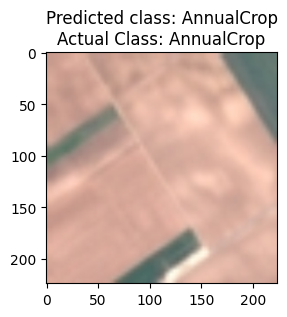

In [44]:
# Retrieve sample image.
index = 15
image, label = test_data[index]

# Predict on sample.
model = model.to("cpu")
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label.
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction.
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize = (3, 3))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

Run the model on a PIL image.

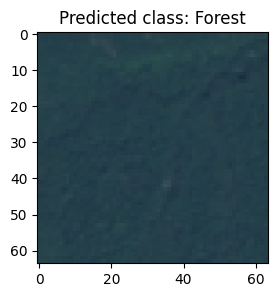

In [46]:
image_path = "./EuroSAT/2750/Forest/Forest_2.jpg"
image = Image.open(image_path)

# Transform image
input = test_transform(image)

# Predict on sample
output = model(input.unsqueeze(0))

# Get corresponding class label
_, pred = torch.max(output, 1)
pred = class_names[pred[0]]

# Visualize results
fig, ax = plt.subplots(figsize = (3,3))
ax.imshow(image)
ax.set_title("Predicted class: {}".format(pred));